In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM

### Load data

In [2]:
# Load datacube

fp_data = "/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/20191117_aSi_200kV_ca0p51_cl300_30x30_5nmstep_exp0p1.dm4"
dc = py4DSTEM.file.io.read(fp_data)
dc.set_scan_shape(30,30)
dc.data = np.roll(dc.data,axis=1,shift=-2)

/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/20191117_aSi_200kV_ca0p51_cl300_30x30_5nmstep_exp0p1.dm4 is not a py4DSTEM file.
Reading with hyperspy...


In [4]:
# Read processing file

fp_processing = "/media/AuxDriveB/Data/20191118_aSI_FEM_ShitengEllis/processing_0p51mrad.h5"
browser = py4DSTEM.file.io.FileBrowser(fp_processing)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    average_DP                          DiffractionSlice    
   1    braggvectormap_shiftcorrected       DiffractionSlice    
   2    braggvectormap_uncorrected          DiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffractionshifts                   RealSlice           
   5    ellipse_params                      PointList           
   6    braggpeaks_shiftcorrected           PointListArray      
   7    braggpeaks_uncorrected              PointListArray      


In [5]:
# Get processing data

aveDP = browser.get_dataobject('average_DP').data
diffractionshifts = browser.get_dataobject('diffractionshifts')
ellipse_params = browser.get_dataobject('ellipse_params')
browser.close()

ellipse_params1 = (ellipse_params.data['x0'][0],ellipse_params.data['y0'][0], ellipse_params.data['A'][0], ellipse_params.data['B'][0], ellipse_params.data['phi'][0])
ellipse_params2 = (ellipse_params.data['x0'][1],ellipse_params.data['y0'][1], ellipse_params.data['A'][1], ellipse_params.data['B'][1], ellipse_params.data['phi'][1])
ellipse_params3 = (ellipse_params.data['x0'][2],ellipse_params.data['y0'][2], ellipse_params.data['A'][2], ellipse_params.data['B'][2], ellipse_params.data['phi'][2])

### Polar-elliptical transform

In [6]:
from py4DSTEM.process.utils import cartesianDataAr_to_polarEllipticalDataAr

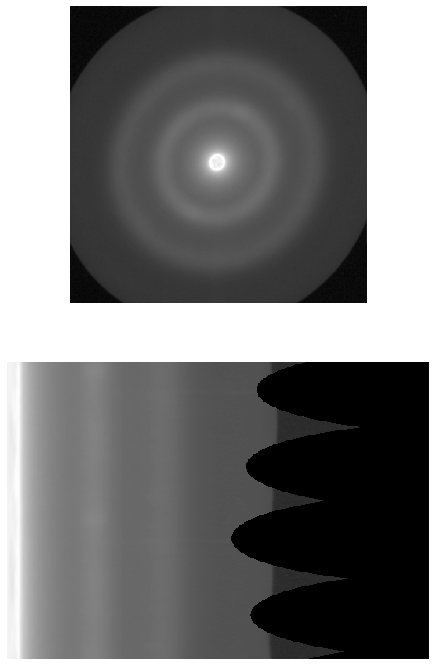

In [7]:
# Polar-elliptical transform

power = 0.2

polarEllipticalData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                                    cartesianData=aveDP,
                                    params=ellipse_params3,
                                    dr=1,
                                    r_range=512,
                                    dtheta=np.radians(1),
                                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(aveDP**power)
ax2.matshow(polarEllipticalData.data**power)
ax1.axis('off')
ax2.axis('off')
plt.show()

In [40]:
# All polar-elliptical transforms

polar_elliptical_transforms = np.ma.array(data=np.zeros((polarEllipticalData.shape[0],polarEllipticalData.shape[1],dc.R_Nx,dc.R_Ny)),
                                          mask=np.zeros((polarEllipticalData.shape[0],polarEllipticalData.shape[1],dc.R_Nx,dc.R_Ny)))
for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        x0 = ellipse_params3[0] + diffractionshifts.slices['x'][Rx,Ry]
        y0 = ellipse_params3[1] + diffractionshifts.slices['y'][Rx,Ry]
        A,B,phi = ellipse_params3[2:]
        polar_elliptical_transform,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                                    cartesianData=dc.data[Rx,Ry,:,:],
                                    params=(x0,y0,A,B,phi),
                                    dr=1,
                                    r_range=512,
                                    dtheta=np.radians(1),
                                    mask=None
        )
        polar_elliptical_transforms.data[:,:,Rx,Ry] = polar_elliptical_transform.data
        polar_elliptical_transforms.mask[:,:,Rx,Ry] = polar_elliptical_transform.mask

In [41]:
ave_im = np.average(dc.data,axis=(2,3))

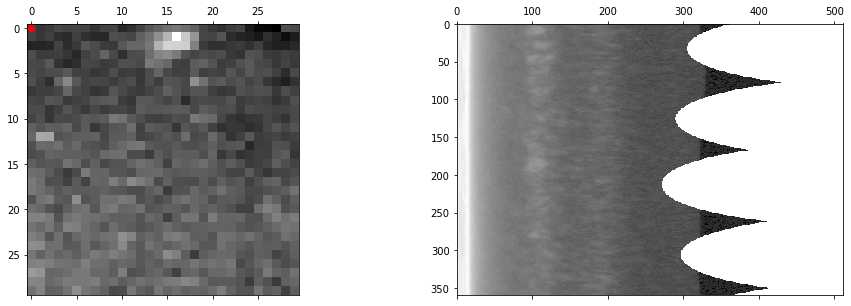

In [42]:
Rx,Ry = 0,0
power = 0.2

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_im)
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(polar_elliptical_transforms[:,:,Rx,Ry]**power)
plt.show()

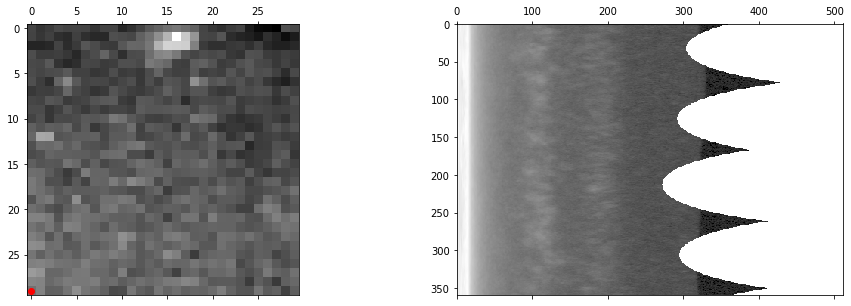

In [43]:
Rx,Ry = 29,0
power = 0.2

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_im)
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(polar_elliptical_transforms[:,:,Rx,Ry]**power)
plt.show()

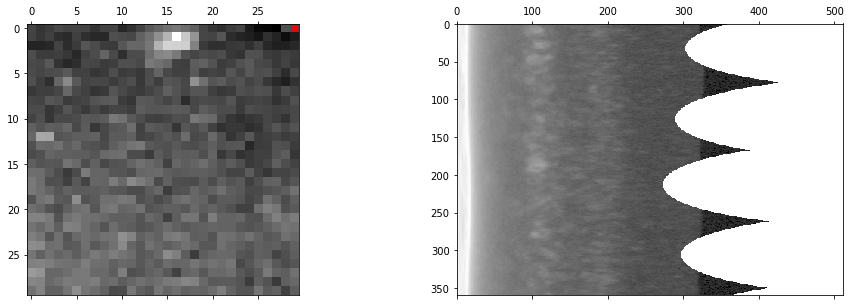

In [44]:
Rx,Ry = 0,29
power = 0.2

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_im)
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(polar_elliptical_transforms[:,:,Rx,Ry]**power)
plt.show()

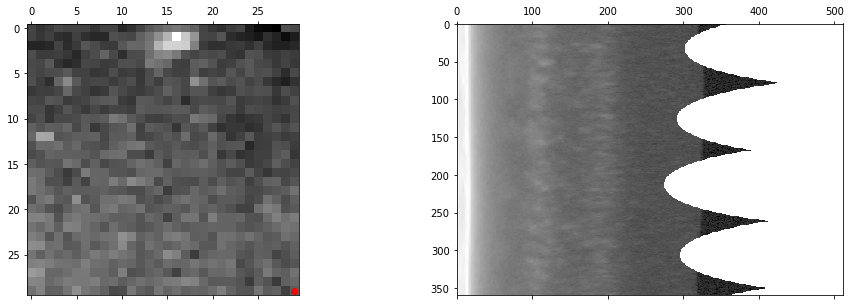

In [45]:
Rx,Ry = 29,29
power = 0.2

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.matshow(ave_im)
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(polar_elliptical_transforms[:,:,Rx,Ry]**power)
plt.show()

### FEM

We generate FEM curves two ways.  In each case, we need $I(q)$ and $V(q)$, the mean and standard deviations of the diffraction intensity as a function of $q$.  What's different in the two approaches is how $V(q)$ is found.

1. (the standard approach): get curves of the mean intensity vs. q at each scan position, then in each bin find the variance amongst these curves.
2. (the colin approach): from the polar-elliptical transform, get the variance along each $q$ value directly

Either way, we then calculate $V(q)/\langle I(q) \rangle^2$.

In [60]:
Ntheta,Nr,_,_ = polar_elliptical_transforms.shape

In [156]:
# Mean statistics

Iq_mean = np.mean(polar_elliptical_transforms,axis=0)

# Method 1
Iq_1D_mean = np.mean(Iq_mean,axis=(1,2))
Vq_method1_mean = np.std(Iq_mean,axis=(1,2))**2
FEM_standard_mean = Vq_method1_mean/(Iq_1D_mean**2)

# Method 2
Vq_method2_mean = np.mean((polar_elliptical_transforms - np.tile(Iq_mean[np.newaxis,:,:,:],(Ntheta,1,1,1)))**2,axis=0)
FEM_hybrid_mean = np.mean(Vq_method2_mean,axis=(1,2))/(Iq_1D_mean**2)
FEM_ring_mean = np.mean(Vq_method2_mean/(Iq_mean**2),axis=(1,2))

rbins = rr[0,:]

In [158]:
# Median statistics

Iq_median = np.median(polar_elliptical_transforms,axis=0)

# Method 1
Iq_1D_median = np.mean(Iq_median,axis=(1,2))
Vq_method1_median = np.std(Iq_median,axis=(1,2))**2
FEM_standard_median = Vq_method1_median/(Iq_1D_median**2)

# Method 2
Vq_method2_median = np.median((polar_elliptical_transforms - np.tile(Iq_median[np.newaxis,:,:,:],(Ntheta,1,1,1)))**2,axis=0)
FEM_hybrid_median = np.mean(Vq_method2_median,axis=(1,2))/(Iq_1D_median**2)
FEM_ring_median = np.mean(Vq_method2_median/(Iq_median**2),axis=(1,2))

rbins = rr[0,:]

/home/ben/Software/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


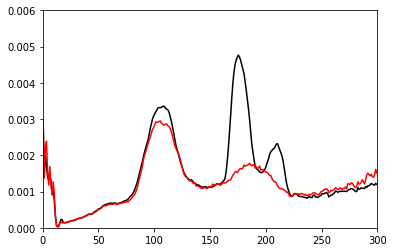

In [159]:
fig,ax = plt.subplots()
ax.plot(rbins,FEM_standard_mean, color='k')
ax.plot(rbins,FEM_standard_median, color='r')
ax.set_ylim(0,.006)
ax.set_xlim(0,300)
plt.show()

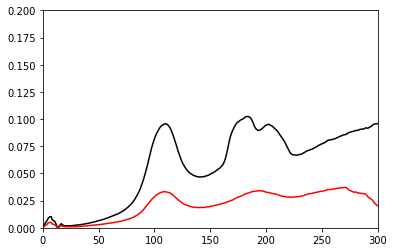

In [160]:
fig,ax = plt.subplots()
ax.plot(rbins,FEM_ring_mean, color='k')
ax.plot(rbins,FEM_ring_median, color='r')
ax.set_ylim(0,.2)
ax.set_xlim(0,300)
plt.show()

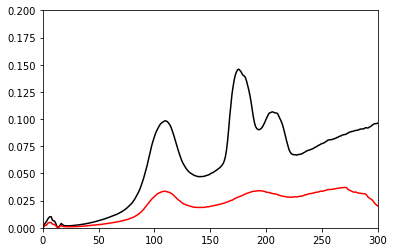

In [161]:
fig,ax = plt.subplots()
ax.plot(rbins,FEM_hybrid_mean, color='k')
ax.plot(rbins,FEM_hybrid_median, color='r')
ax.set_ylim(0,.2)
ax.set_xlim(0,300)
plt.show()

### Plots for figure

In [162]:
medianDP = np.median(dc.data,axis=(0,1))
maxDP = np.max(dc.data,axis=(0,1))

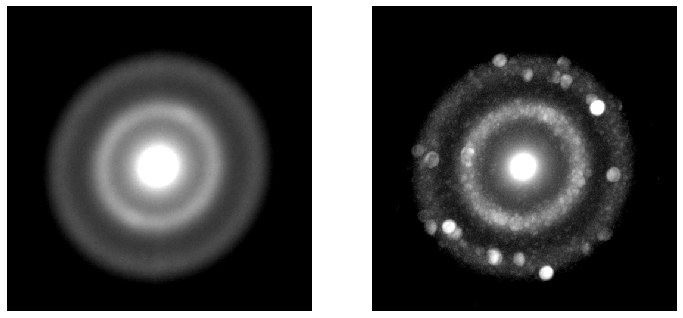

In [181]:
power = 0.2
nstd_median = 2
nstd_max = 3

maxDP_plot = maxDP**power
medianDP_plot = medianDP**power

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(medianDP_plot, vmin=np.mean(medianDP_plot), vmax=np.mean(medianDP_plot)+nstd_median*np.std(medianDP_plot))
ax2.matshow(maxDP_plot, vmin=np.mean(maxDP_plot), vmax=np.mean(maxDP_plot)+nstd_max*np.std(maxDP_plot))
ax1.axis('off')
ax2.axis('off')
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/fem/diffractionpatterns.pdf")
plt.show()

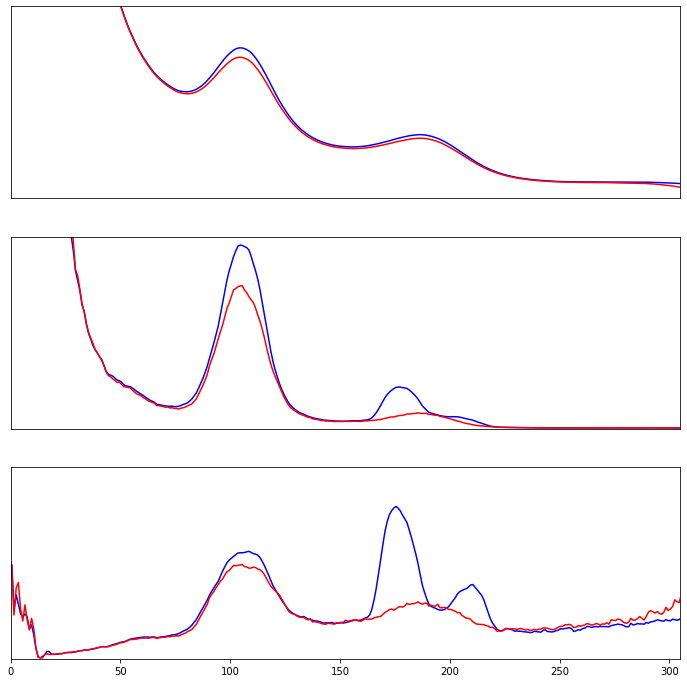

In [183]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,12))
ax1.plot(rbins,Iq_1D_mean,color='b')
ax2.plot(rbins,Vq_method1_mean,color='b')
ax3.plot(rbins,FEM_standard_mean, color='b')
ax1.plot(rbins,Iq_1D_median,color='r')
ax2.plot(rbins,Vq_method1_median,color='r')
ax3.plot(rbins,FEM_standard_median, color='r')
ax1.set_xlim(0,305)
ax2.set_xlim(0,305)
ax3.set_xlim(0,305)
ax1.set_ylim(0,750)
ax2.set_ylim(0,1200)
ax3.set_ylim(0,.006)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_xticks([])
ax2.set_xticks([])
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/fem/Iq_Vq_FEM_plots.pdf")
plt.show()